##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# アテンションを用いたニューラル機械翻訳

このノートブックはTensorFlowの公式ページを基にして作られています。

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/text/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

公式ページではこの記事とは別の解説もあります。

公式ページと合わせてお読みいただくとより理解が深まります。

このノートブックでは、日本語から英語への翻訳を行う Sequence to Sequence (seq2seq) モデルを訓練します。
_"車が好きです。"_  のような日本語の文を入力して、英訳：  _"i like the car ."_  を得ることができます。


Note: このサンプルは P100 GPU 1基で実行した場合に約 90 分かかります。

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## データセットのダウンロードと準備

ここでは、http://www.manythings.org/anki/ で提供されている言語データセットを使用します。このデータセットには、次のような書式の言語翻訳ペアが含まれています。

英語－スペイン語データは以下となります。

```
May I borrow this book?	¿ｿPuedo tomar prestado este libro?	CC-BY 2.0 (France) Attribution: tatoeba.org #56836 (CK) & #1677842 (teskmon)
```

なお、英語－日本語データは以下となります。

```
What time is school over?	学校は何時に終わるの？	CC-BY 2.0 (France) Attribution: tatoeba.org #9713591 (DJ_Saidez) & #10206436 (small_snow)

```



データセットをダウンロードしたあと、データを準備するために下記のようないくつかの手順を実行します。

1. それぞれの文ごとに、*開始* と *終了* のトークンを付加する
2. 特殊文字を除去して文をきれいにする
3. 単語インデックスと逆単語インデックス（単語 → id と id → 単語のマッピングを行うディクショナリ）を作成する
4. 最大長にあわせて各文をパディングする

In [2]:
# ファイルのダウンロード
!wget = 'http://www.manythings.org/anki/jpn-eng.zip'
# ファイルの展開
!unzip -o jpn-eng.zip
path_to_file = "/content/jpn.txt"

--2023-07-09 06:19:50--  http://=/
Resolving = (=)... failed: Name or service not known.
wget: unable to resolve host address ‘=’
--2023-07-09 06:19:50--  http://www.manythings.org/anki/jpn-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4200489 (4.0M) [application/zip]
Saving to: ‘jpn-eng.zip’

jpn-eng.zip         100%[===================>]   4.01M  3.82MB/s    in 1.0s    

2023-07-09 06:19:51 (3.82 MB/s) - ‘jpn-eng.zip’ saved [4200489/4200489]

FINISHED --2023-07-09 06:19:51--
Total wall clock time: 1.7s
Downloaded: 1 files, 4.0M in 1.0s (3.82 MB/s)
Archive:  jpn-eng.zip
  inflating: jpn.txt                 
  inflating: _about.txt              


最初の10行の表示

In [3]:
!head jpn.txt

Go.	行け。	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7421985 (Ninja)
Go.	行きなさい。	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7421986 (Ninja)
Hi.	こんにちは。	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #373351 (tommy_san)
Hi.	もしもし。	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #385517 (mookeee)
Hi.	やっほー。	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #3480285 (arnab)
Hi.	こんにちは！	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #3480287 (arnab)
Run.	走れ。	CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #5955868 (tatoebane)
Run.	走って！	CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #5955869 (tatoebane)
Who?	誰？	CC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #638666 (arihato)
Wow!	すごい！	CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #214733 (arihato)


最後の10行の表示

In [4]:
!tail jpn.txt

Five tremors in excess of magnitude 5.0 on the Richter scale have shaken Japan just this week, but scientists are warning that the largest expected aftershock has yet to hit.	日本ではリヒター・スケールでマグニチュード5.0以上の余震が今週5回ありました。しかし科学者たちは、最大規模の余震はまだ先に起こりうると警告しています。	CC-BY 2.0 (France) Attribution: tatoeba.org #912384 (Source_VOA) & #913502 (thyc244)
The bus now arriving is going to Domestic Terminal 1. Passengers for the International Terminal, please wait. The shuttle bus to the International Terminal also leaves from this stop.	ただ今到着のバスは、国内線第1ターミナル行きです。国際線ターミナルにお越しの方は、しばらくそのままでお待ちください。国際線行き連絡バスもこのバス停から発車いたします。	CC-BY 2.0 (France) Attribution: tatoeba.org #4871909 (CK) & #4871830 (tommy_san)
A child who is a native speaker usually knows many things about his or her language that a non-native speaker who has been studying for years still does not know and perhaps will never know.	ネイティブの子どもは、何年も学んだ非ネイティブが知らず今後も知り得ないたくさんのことを自身の言語について知っているものだ。	CC-BY 2.0 (France) Attribution: tatoeba.org #953070 (CK) & #9

###ユニコードファイルを ascii に変換するための関数

In [5]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

日本語の場合は以下をインストールしてから実行

In [6]:
!pip install janome

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 44.8 MB/s eta 0:00:00


In [7]:
from janome.tokenizer import Tokenizer

In [8]:
janome_tokenizer = Tokenizer(wakati=True)

### 以下の２つを行うための関数

1.  単語とそのあとの句読点の間にスペースを挿入

```
he is a boy. => he is a boy .
```

2.  文の開始(\<start\>)と終了(\<end\>)のトークンを付加

```
he is a boy .=> <start> he is a boy . <end>
```

In [9]:
#日本語用に改造済み
def preprocess_sentence(w):
	if re.search(r'[ぁ-ん]+|[ァ-ヴー]+|[一-龠]+', w)==None:
#	if len(w) == len(w.encode('utf-8')):
		#英語，スペイン語の場合の処理
		w = unicode_to_ascii(w.lower().strip())
		w = re.sub(r"([?.!,¿])", r" \1 ", w)
		w = re.sub(r'[" "]+', " ", w)
		w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
		w = w.rstrip().strip()

		# 文の開始と終了のトークンを付加
		# モデルが予測をいつ開始し、いつ終了すれば良いかを知らせるため
		w = '<start> ' + w + ' <end>'
	else:
		#日本語の場合の処理
		print(w)
#    print(w)
		tokenized_text = janome_tokenizer.tokenize(w)
		w = ""
		for tt in list(tokenized_text):
			w = w + str(tt) + ' '
		w = '<start> ' + w + '<end>'
	return w


どのように変換されるのか試す部分
（必ずしも必要ではない）

In [10]:
en_sentence = u"May I borrow this book?"
jp_sentence = "この本を借りてもいいですか。"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(jp_sentence))

<start> may i borrow this book ? <end>
この本を借りてもいいですか。
<start> この 本 を 借り て も いい です か 。 <end>


### 以下の３つを行うための関数
1.   アクセント記号を除去
2.   文をクリーニング
3.   **【ポイント】[JAPANESE, ENGLISH] の形で単語のペアを返す**

In [11]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    w0,w1,w2 = zip(*word_pairs)

    return w1,w0,w2

###学習データを読み込むための関数

２つ目の引数が読み込む例文数を示している。
Noneとすることですべて読み込む。

In [12]:
jp, en, lic = create_dataset(path_to_file, None)

ストリーミング出力は最後の 5000 行に切り捨てられました。
容易に理解できるような本を読みなさい。
数千人がこの病気の犠牲になった。
この病気で数千の犠牲者が出た。
彼女は自分を裏切ったとして夫を厳しく責めた。
彼女は不誠実であったことで夫を責めた。
彼女は売り子だったことを秘密にしていた。
彼女は自分が美人だとうぬぼれている。
彼女は小さな驚きの悲鳴を上げると、浴室に逃げて行った。
彼女はその事件を調べるのに私立探偵を雇った。
彼女は２歳だが、もう１００まで数えられる。
彼女は若そうに見えるが、実際はあなたより年上です。
彼女は若く見えるけど、実のところあなたより年上なんです。
彼女は健康のためにもっと温かいところへ引っ越した。
この詩を書いたときは、彼女はとても若かったにちがいない。
この詩を書いたとき彼女はとても若かったはずだ。
彼女は仕事をしている時間よりも、仕事について考えている時間の方が長い。
彼女は事故の後丸一日意識不明だった。
彼女は、一昨年よりもはるかに暮らし向きがよい。
零細企業はインフレで苦境に陥っています。
その計画に賛成の者もいれば反対の者もいる。
話上手もいれば、聞き上手もいる。
お金のために本を書く人もいれば、楽しみで書く人もいる。
テレビは意外と電気をくう。
風が強い日はテニスができません。
こんなに素敵なプレゼントを送ってくれて、本当にありがとう。
あの少女は自分が王女様だという妄想にとらわれている。
あの老人は５０年も自家製ウイスキーを作っていた。
あの店は安いですが、まずいです。
あれは私が今まで読んだうちで一番面白い小説だった。
アメリカ大統領が中国を公式に訪問した。
ソ連軍はアフガニスタンからの撤退を開始した。
著者は自分の本に多くの挿し絵を入れた。
とても寒かったのにもかかわらず、その子供はオーバーコートを身につけていなかった。
子供たちは、クリスマス会でプレゼント交換をしました。
子供たちはソファの上で跳び始めた。
子供らは、ソファーの上でピョンピョンし始めた。
委員会は男性３人、女性７人で構成されている。
君の夢が実現する日が必ず来るだろう。
君の夢が実現する日は必ず来るだろう。
あなたの夢が叶う日がきっと来るわ。
医者は患者の胸に聴診器を当てた。
この辞書の用例はわかりやすい。
食堂のごはんは安いです。そして、お

どのように変換されるのか試す部分
（必ずしも必要ではない）

-1とすることで最後の１文を表示している。
10とすれば10行目が表示される。

In [13]:
print(en[200])
print(jp[200])

<start> hold on . <end>
<start> お待ち ください 。 <end>


In [14]:
print(en[30000])
print(jp[30000])

<start> you re wrong about that . <end>
<start> その こと について 君 は 間違っ てる よ 。 <end>


In [15]:
print(en[-1])
print(jp[-1])

<start> i went drinking with one of my boyfriend s friends , and now he s furious at me . was this friend a guy or a girl ? a guy , obviously . why would i go drinking with his female friends ? yeah , you re right . his name is tom . he s really hot , and i really want to go drinking with him again . <end>
<start> 「 彼氏 の 友達 と 飲み に 行っ たら 彼 に 激怒 さ れ ちゃっ た 」 「 その 『 友達 』 って 、 男 ？ 女 ？ 」 「 男 に 決まっ てる でしょ 。 どうして 、 彼氏 の 女 友達 と 飲み に 行か なきゃ いけ ない の ？ 」 「 そりゃ そう だ 」 「 彼 ね トム って 言う ん だ けど 、 めっちゃ イケ てる の 。 また 行き たい な 」 <end>


### 読み込んだ学習データの最大の単語数（句読点も含む）を調べるための関数

In [16]:
def max_length(tensor):
    return max(len(t) for t in tensor)

### TensorFlowで扱いやすい形に変換するための関数

ここでは、最大の単語数になるように0で埋めて長さを調整しています。

例：最大の単語数が11だった場合、以下の例文は長さが足りないので、0を4つ足して入力データとします。

```
<start> i was expecting you . <end>
1 4 26 1045 6 3 2 0 0 0 0
```


In [17]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

### データを読み込んで整理するまでを1つにまとめた関数

In [18]:
def load_dataset(path, num_examples=None):
    # クリーニングされた入力と出力のペアを生成
    targ_lang, inp_lang, lic = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### 実験を速くするためデータセットのサイズを制限（オプション）

100,000 を超える文のデータセットを使って訓練するには長い時間がかかります。訓練を速くするため、データセットのサイズを 30,000 に制限することができます（もちろん、データが少なければ翻訳の品質は低下します）。

日本語の場合は90,000位に増やしておくとうまく翻訳できるようになります。

In [19]:
# このサイズのデータセットで実験
num_examples = 90000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# ターゲットテンソルの最大長を計算
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

ストリーミング出力は最後の 5000 行に切り捨てられました。
トムは押し入れに掃除機をしまいました。
トムは、砂糖のかわりにハチミツを紅茶にいれます。
トムはメアリーは疲れてないと思ったと言った。
トムがオーストラリアに行きたいってさ。
トムが君はメアリーよりフランス語を喋るのがうまいと言った。
トムは皿を洗いながら、歌を口ずさんだ。
トムは、メアリーが公園のベンチで一人で座っているのを見た。
トムはジョンのしたことをメアリーに話すべきではなかった。
トムはそんな失礼なことをメアリーに言うべきではない。
トムはメアリーに自分の家の写真をいくつか見せた。
トムは彼女にサンタクロースからの手紙を見せた。
トムは一日八時間、コンピューターに向かっている。
トムは出発しようとしたが、メアリーが彼を止めた。
トムはふと、一人じゃないことに気付いた。
トムは私たちの秘密を誰にも言っていないと断言した。
トムは私たちの秘密を誰にも言っていないと言い切った。
トムはタップダンスのレッスンを週に２回受けているんだ。
スポーツは時間の無駄だって、トムは思っているんだよ。
トムはパスポートを持ってないって言ってたよ。
どこでザクロが買えるのか、トムが教えてくれたんだ。
トムは私が子供の時、サーカスに連れて行ってくれた。
トムがフランス語の小説を英語に翻訳したんだ。
トムって、フランス語の小説を英語に訳したのよ。
トムは明かりを消して部屋を後にした。
トムは今よりすごい太っていた。
トムはかつて今よりお金持ちだった。
トムは質問をしたかったが、しなかった。
トムはメアリーが誰と話しているか知りたかった。
トムって、同時通訳になりたがってるんだ。
トムは自分の評判を守るのに必死だった。
トムはパジャマで新聞を読んでいた。
トムはマリアが死んだと聞いてショックを受けた。
トムはね、去年まで私より背が低かったんだよ。
その洞窟に最初に入ったのは、トムなんだよ。
パーティーに来たのはトムだけだった。
トムは涙ながらにテレビを見ていた。
トムは自分のやりたいことができなかった。
トムなら、ストーブの灯油を買いに行ったよ。
トムは僕らと何日間か滞在します。
トムはハンカチで額を拭った。
トムは私達と一緒にオーストラリアに行かないんだよね？
トムの行動にはいつも驚かされる。
トムのうるさいいびきで一睡

In [20]:
# 80-20で分割を行い、訓練用と検証用のデータセットを作成
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 長さを表示
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

72000 72000 18000 18000


文章をIDと単語の関係として表示するための関数です。

これはどのように動作しているかを示すための関数ですので必ずしも必要ではありません。

In [21]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))
    else:
      print(t)

In [22]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
26 ----> are
6 ----> you
874 ----> guys
4756 ----> idiots
7 ----> ?
2 ----> <end>
0
0
0
0
0
0
0
0
0
0

Target Language; index to word mapping
1 ----> <start>
6747 ----> てめえ
747 ----> ら
1002 ----> 馬鹿
18 ----> か
12 ----> ？
2 ----> <end>
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


### tf.data データセットの作成

In [23]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [24]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 17]), TensorShape([64, 30]))

## エンコーダー・デコーダーモデルの記述

### エンコーダモデル

In [25]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
#    x = self.embedding(x)
#    output, state = self.gru(x, initial_state = hidden)
#    return output, state, x
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

エンコーダの動作を示す部分

In [26]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# サンプル入力
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
#sample_output, sample_hidden, x = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))
#print ('Encoder Embedding shape: (batch size, units) {}'.format(x.shape))

Encoder output shape: (batch size, sequence length, units) (64, 17, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [27]:
example_input_batch

<tf.Tensor: shape=(64, 17), dtype=int32, numpy=
array([[   1,   32,    9, ...,    0,    0,    0],
       [   1,   45,   52, ...,    0,    0,    0],
       [   1,   27,   12, ...,    0,    0,    0],
       ...,
       [   1,   36,  108, ...,    0,    0,    0],
       [   1,    5, 5134, ...,    0,    0,    0],
       [   1,    4,   27, ...,    0,    0,    0]], dtype=int32)>

### アテンション

In [28]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # スコアを計算するためにこのように加算を実行する
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # スコアを self.V に適用するために最後の軸は 1 となる
    # self.V に適用する前のテンソルの shape は  (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights の shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector の合計後の shape == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

アテンションの動作を示す部分

In [29]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 17, 1)


### デコーダモデル

In [30]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # アテンションのため
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output の shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # 埋め込み層を通過したあとの x の shape  == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # 結合後の x の shape == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # 結合したベクトルを GRU 層に渡す
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

デコーダの動作を示す部分

In [31]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 16396)


## オプティマイザと損失関数の定義

In [32]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## チェックポイント（オブジェクトベースの保存）

In [33]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## 訓練

1. *入力* を *エンコーダー* に通すと、*エンコーダー出力* と *エンコーダーの隠れ状態* が返される
2. エンコーダーの出力とエンコーダーの隠れ状態、そしてデコーダーの入力（これが *開始トークン*）がデコーダーに渡される
3. デコーダーは *予測値* と *デコーダーの隠れ状態* を返す
4. つぎにデコーダーの隠れ状態がモデルに戻され、予測値が損失関数の計算に使用される
5. デコーダーへの次の入力を決定するために *Teacher Forcing* が使用される
6. *Teacher Forcing* は、*正解単語* をデコーダーの *次の入力* として使用するテクニックである
7. 最後に勾配を計算し、それをオプティマイザに与えて誤差逆伝播を行う

In [34]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher Forcing - 正解値を次の入力として供給
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # Teacher Forcing を使用
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [35]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # 2 エポックごとにモデル（のチェックポイント）を保存
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.9974
Epoch 1 Batch 100 Loss 1.6460
Epoch 1 Batch 200 Loss 1.5214
Epoch 1 Batch 300 Loss 1.4453
Epoch 1 Batch 400 Loss 1.2704
Epoch 1 Batch 500 Loss 1.2877
Epoch 1 Batch 600 Loss 1.2353
Epoch 1 Batch 700 Loss 1.2188
Epoch 1 Batch 800 Loss 1.0880
Epoch 1 Batch 900 Loss 1.1458
Epoch 1 Batch 1000 Loss 1.2231
Epoch 1 Batch 1100 Loss 1.0811
Epoch 1 Loss 1.3094
Time taken for 1 epoch 350.54482793807983 sec

Epoch 2 Batch 0 Loss 1.0200
Epoch 2 Batch 100 Loss 0.9388
Epoch 2 Batch 200 Loss 1.0518
Epoch 2 Batch 300 Loss 1.0589
Epoch 2 Batch 400 Loss 0.9083
Epoch 2 Batch 500 Loss 0.9720
Epoch 2 Batch 600 Loss 0.9954
Epoch 2 Batch 700 Loss 0.9237
Epoch 2 Batch 800 Loss 0.8276
Epoch 2 Batch 900 Loss 0.9080
Epoch 2 Batch 1000 Loss 0.8126
Epoch 2 Batch 1100 Loss 0.7844
Epoch 2 Loss 0.9363
Time taken for 1 epoch 298.7906024456024 sec

Epoch 3 Batch 0 Loss 0.7716
Epoch 3 Batch 100 Loss 0.7277
Epoch 3 Batch 200 Loss 0.7280
Epoch 3 Batch 300 Loss 0.7738
Epoch 3 Batch 400 Loss 0.6979

## 翻訳

* 評価関数は、*Teacher Forcing* を使わないことを除いては、訓練ループと同様である。タイムステップごとのデコーダーへの入力は、過去の予測値に加えて、隠れ状態とエンコーダーのアウトプットである。
* モデルが *終了トークン* を予測したら、予測を停止する。
* また、*タイムステップごとのアテンションの重み*を保存する。

Note: エンコーダーの出力は 1 つの入力に対して 1 回だけ計算されます。

In [36]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 後ほどプロットするためにアテンションの重みを保存
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 予測された ID がモデルに戻される
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

### アテンションの重みをプロットする関数

In [37]:
# アテンションの重みをプロットする関数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

### 翻訳する文章を引数とすると翻訳結果を表示する関数

In [38]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## 最後のチェックポイントを復元しテストする

In [39]:
# checkpoint_dir の中の最後のチェックポイントを復元
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

日本語を表示するためのライブラリのインストール

In [40]:
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 63.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=5f79ba3f1fba16605e8c47b04cda0a5c389e040b5643a593af8e7e0f3586c516
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [41]:
import japanize_matplotlib

## 例文でテスト

※日本語はgoogle翻訳によるものです。

### 例文1:

英語
```
It is really cold here.
（ここは本当に寒いです。）
```

日本語
```
ここ は とても 寒い よ 。
```



Input: <start> it is really cold here . <end>
Predicted translation: ここ は とても 寒い なぁ 。 <end> 


<ipython-input-37-5ef4cab55ead>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-37-5ef4cab55ead>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


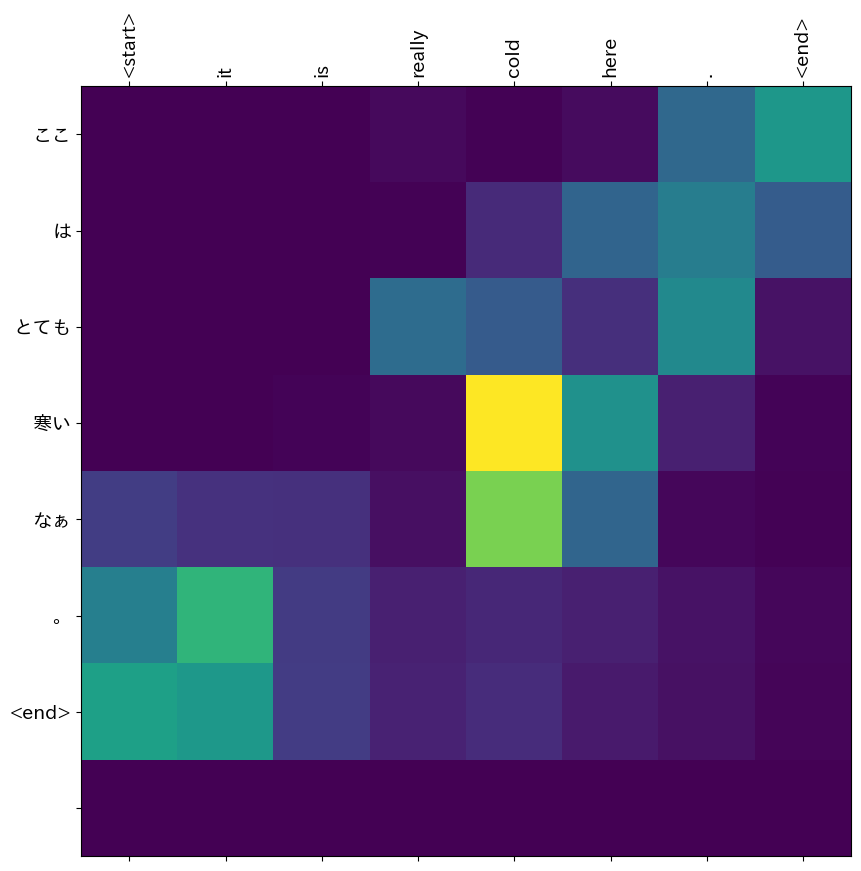

In [42]:
translate(u'It is really cold here.')

### 例文2:

英語
```
This is my life.
（これが私の人生です。）
```

日本語
```
こちら が 私 の 母国 です 。
```


Input: <start> this is my life . <end>
Predicted translation: これ で 私 の 人生 そのもの な ん だ 。 <end> 


<ipython-input-37-5ef4cab55ead>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-37-5ef4cab55ead>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


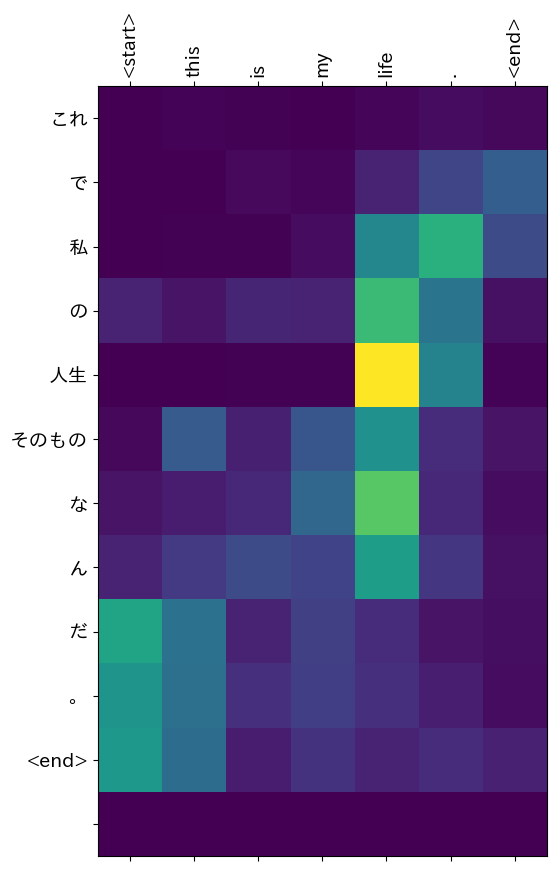

In [43]:
translate(u'This is my life.')

###例文3:

英語
```
Are you still at home?
（あなたはまだ家にいますか？）
```

日本語
```
まだ 家 に いる ？
```


Input: <start> are you still at home ? <end>
Predicted translation: まだ 家 に いる の ？ <end> 


<ipython-input-37-5ef4cab55ead>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-37-5ef4cab55ead>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


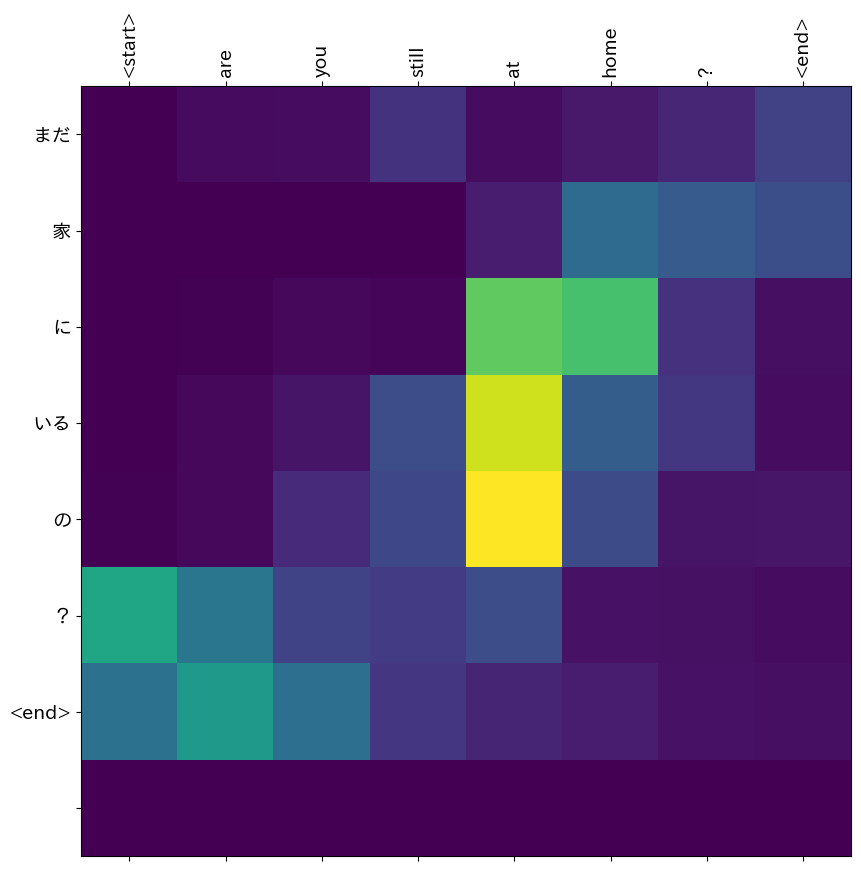

In [44]:
translate(u'Are you still at home?')

###例文4:誤りの例


英語
```
Try to find out.
（調べてみてください。）
```

日本語
```
さっさと 出 て い なさい 。
```


Input: <start> try to find out . <end>
Predicted translation: 外 を 見 て み なさい 。 <end> 


<ipython-input-37-5ef4cab55ead>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-37-5ef4cab55ead>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


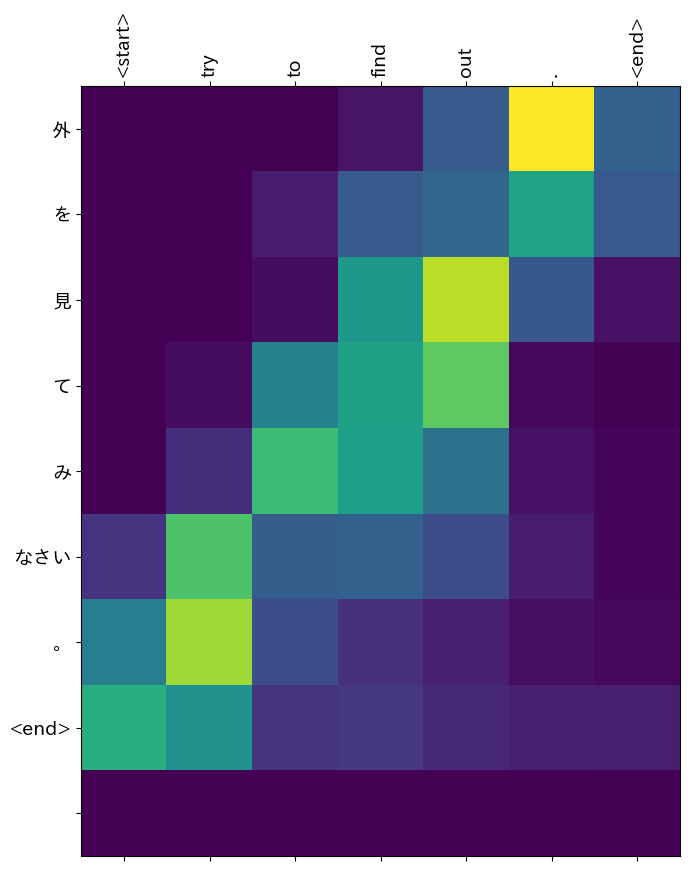

In [45]:
# 翻訳あやまりの例
translate(u'Try to find out.')

###例文5:長い原文を入力として使う

英語
```
Let me think about it and I will get back to you.
（考えさせてください。折り返しご連絡いたします。）
```

日本語
```
その こと が ご 連絡 申し上げ ます 。
```

原文（87329行目）
```
Let me think about it and I'll get back to you.
この件につきましては、考えるお時間をいただけますか。こちらからまた改めてご連絡申し上げます。
```


Input: <start> let me think about it and i will get back to you . <end>
Predicted translation: 私 に 考え させ たら 、 私 が よ 。 <end> 


<ipython-input-37-5ef4cab55ead>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-37-5ef4cab55ead>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


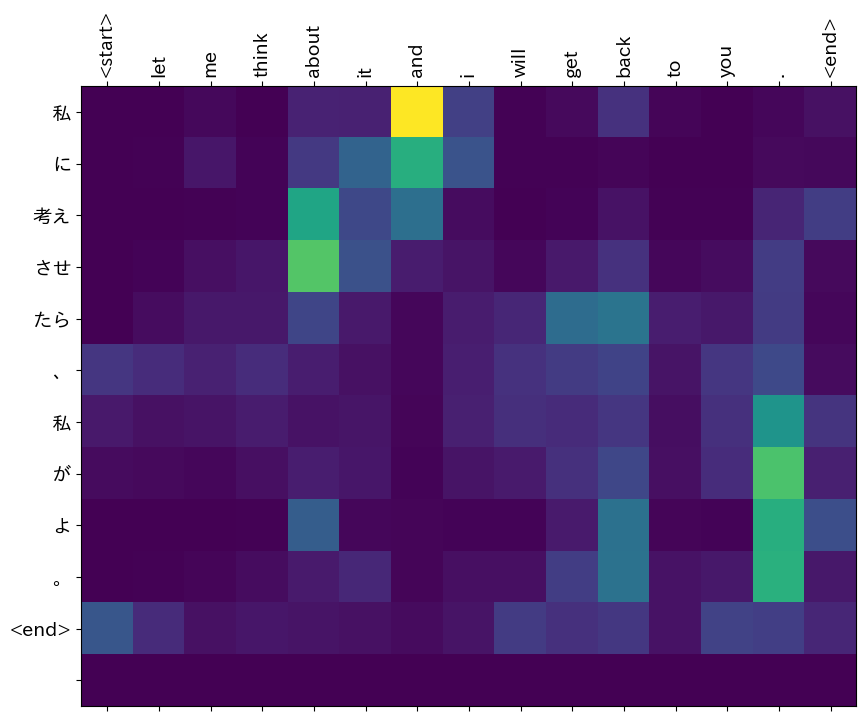

In [46]:
translate(u'Let me think about it and I will get back to you.')